# Importing required Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import zipfile
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Downloading Required Libraries for NLTK package

In [2]:
nltk.download('wordnet',download_dir='/kaggle/working/')
nltk.data.path.append('/kaggle/working/')

with zipfile.ZipFile('/kaggle/working/corpora/wordnet.zip','r') as file:
    file.extractall('/kaggle/working/corpora/')

[nltk_data] Downloading package wordnet to /kaggle/working/...


# Reading Excel Sheet

In [3]:
df=pd.read_excel('/kaggle/input/restaurants-price/restraunt.xlsx')
df.head()

,Id,Restaurant-Name,Phone,Address,Item-Name,Item-type,Description,Price
0,1,Village - The Soul of India,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",Rasam,Soups and Salad,South Indian spiced Lentil soup,4.95
1,2,Village - The Soul of India,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",Sambar,Soups and Salad,Lentil based Vegetable soup,4.95
2,3,Village - The Soul of India,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",Mulligatawny Soup,Soups and Salad,Lentil thick soup with pepper & spices,4.95
3,4,Village - The Soul of India,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",Garden Soup,Soups and Salad,Mixed Vegetables Soup,4.95
4,5,Village - The Soul of India,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",Kachumbar Salad,Soups and Salad,Chopped salad dressed with a lemon and spicy v...,4.95


## Copying Data to another variable for Data Manipulation

In [4]:
df2=df.copy()

## Checking Missing Values

In [5]:
df2.isnull().sum()

Id                   0
Restaurant-Name      0
Phone                0
Address              0
Item-Name            0
Item-type            0
Description        280
Price                0
dtype: int64

### Getting values for Village Restaurant and Dataset size

In [6]:
temp=df[df['Restaurant-Name']=="Village - The Soul of India"]
temp.shape

(191, 8)

### Saving this dataset in Pickle format for accessing the Village Restaurant Menu in application

In [7]:
pickle.dump(temp, open('/kaggle/working/Village-menu.pkl','wb'))

## Now Handling Missing value feature

In [8]:
df.fillna('Not Mentioned',inplace=True)

## Removing Punctuation and special characters from text features

In [9]:
df2['Restaurant-Name']=df['Restaurant-Name'].replace('[^a-zA-Z]', " ", regex=True)
df2['Item-Name']=df['Item-Name'].replace('[^a-zA-Z]', " ", regex=True)
df2['Item-type']=df['Item-type'].replace('[^a-zA-Z]', " ", regex=True)
df2['Description']=df['Description'].replace('[^a-zA-Z]', " ", regex=True)
df2['Restaurant-Name']=df2['Restaurant-Name'].str.lower()
df2['Item-Name']=df2['Item-Name'].str.lower()
df2['Item-type']=df2['Item-type'].str.lower()
df2['Description']=df2['Description'].str.lower()

In [10]:
df2.head()

,Id,Restaurant-Name,Phone,Address,Item-Name,Item-type,Description,Price
0,1,village the soul of india,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",rasam,soups and salad,south indian spiced lentil soup,4.95
1,2,village the soul of india,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",sambar,soups and salad,lentil based vegetable soup,4.95
2,3,village the soul of india,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",mulligatawny soup,soups and salad,lentil thick soup with pepper spices,4.95
3,4,village the soul of india,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",garden soup,soups and salad,mixed vegetables soup,4.95
4,5,village the soul of india,+1 516-506-3655,"11 W Marie St, Hicksville, NY 11801, United St...",kachumbar salad,soups and salad,chopped salad dressed with a lemon and spicy v...,4.95


## Droping Unncessary Features

In [11]:
df2.drop(['Phone', 'Address'],axis=1,inplace=True)

## Reviewing dataset

In [12]:
df2.head()

,Id,Restaurant-Name,Item-Name,Item-type,Description,Price
0,1,village the soul of india,rasam,soups and salad,south indian spiced lentil soup,4.95
1,2,village the soul of india,sambar,soups and salad,lentil based vegetable soup,4.95
2,3,village the soul of india,mulligatawny soup,soups and salad,lentil thick soup with pepper spices,4.95
3,4,village the soul of india,garden soup,soups and salad,mixed vegetables soup,4.95
4,5,village the soul of india,kachumbar salad,soups and salad,chopped salad dressed with a lemon and spicy v...,4.95


## Performing Tokenization over text features

In [13]:
for features in df2.columns:
    if features!='Id' and features!='Price':
        if features=="Item-Name":
            df2[features+"2"]=df2[features].str.split()
        else:
            df2[features]=df2[features].str.split()

In [14]:
df2.head()

,Id,Restaurant-Name,Item-Name,Item-type,Description,Price,Item-Name2
0,1,"[village, the, soul, of, india]",rasam,"[soups, and, salad]","[south, indian, spiced, lentil, soup]",4.95,[rasam]
1,2,"[village, the, soul, of, india]",sambar,"[soups, and, salad]","[lentil, based, vegetable, soup]",4.95,[sambar]
2,3,"[village, the, soul, of, india]",mulligatawny soup,"[soups, and, salad]","[lentil, thick, soup, with, pepper, spices]",4.95,"[mulligatawny, soup]"
3,4,"[village, the, soul, of, india]",garden soup,"[soups, and, salad]","[mixed, vegetables, soup]",4.95,"[garden, soup]"
4,5,"[village, the, soul, of, india]",kachumbar salad,"[soups, and, salad]","[chopped, salad, dressed, with, a, lemon, and,...",4.95,"[kachumbar, salad]"


## Now Merging the lists of features in a Tags feature

In [15]:
df2['Tags']=df2['Item-Name2']+df2['Item-type']+df2['Description']

In [16]:
df2.head()

,Id,Restaurant-Name,Item-Name,Item-type,Description,Price,Item-Name2,Tags
0,1,"[village, the, soul, of, india]",rasam,"[soups, and, salad]","[south, indian, spiced, lentil, soup]",4.95,[rasam],"[rasam, soups, and, salad, south, indian, spic..."
1,2,"[village, the, soul, of, india]",sambar,"[soups, and, salad]","[lentil, based, vegetable, soup]",4.95,[sambar],"[sambar, soups, and, salad, lentil, based, veg..."
2,3,"[village, the, soul, of, india]",mulligatawny soup,"[soups, and, salad]","[lentil, thick, soup, with, pepper, spices]",4.95,"[mulligatawny, soup]","[mulligatawny, soup, soups, and, salad, lentil..."
3,4,"[village, the, soul, of, india]",garden soup,"[soups, and, salad]","[mixed, vegetables, soup]",4.95,"[garden, soup]","[garden, soup, soups, and, salad, mixed, veget..."
4,5,"[village, the, soul, of, india]",kachumbar salad,"[soups, and, salad]","[chopped, salad, dressed, with, a, lemon, and,...",4.95,"[kachumbar, salad]","[kachumbar, salad, soups, and, salad, chopped,..."


## Creating object for lemmatizer

In [17]:
lemmatizer=WordNetLemmatizer()

## Performing Lemmatization Stopwords in Tags feature
- **Lemmatization:** Extracting of root words from a word and transforming it to meaningful word.

  e.g. accessing--> access, creativity --> creative
- **Stopwords:** It is used to remove words which does not have high significance in decision making by the model.

  e.g. a, he, his, himself, are,etc.

In [18]:
wrd_list=[]
for i, words_list in enumerate(df2.loc[:,'Tags']):
    words=[lemmatizer.lemmatize(word) for word in words_list if word not in stopwords.words('english')]
    words=" ".join(words)
    wrd_list.append(words)

### Assigning all these processed words list to Tags feature

In [19]:
df2['Tags']=wrd_list

In [20]:
df2.head()

,Id,Restaurant-Name,Item-Name,Item-type,Description,Price,Item-Name2,Tags
0,1,"[village, the, soul, of, india]",rasam,"[soups, and, salad]","[south, indian, spiced, lentil, soup]",4.95,[rasam],rasam soup salad south indian spiced lentil soup
1,2,"[village, the, soul, of, india]",sambar,"[soups, and, salad]","[lentil, based, vegetable, soup]",4.95,[sambar],sambar soup salad lentil based vegetable soup
2,3,"[village, the, soul, of, india]",mulligatawny soup,"[soups, and, salad]","[lentil, thick, soup, with, pepper, spices]",4.95,"[mulligatawny, soup]",mulligatawny soup soup salad lentil thick soup...
3,4,"[village, the, soul, of, india]",garden soup,"[soups, and, salad]","[mixed, vegetables, soup]",4.95,"[garden, soup]",garden soup soup salad mixed vegetable soup
4,5,"[village, the, soul, of, india]",kachumbar salad,"[soups, and, salad]","[chopped, salad, dressed, with, a, lemon, and,...",4.95,"[kachumbar, salad]",kachumbar salad soup salad chopped salad dress...


## Splitting the output feature for further processing

In [21]:
X=df2[['Item-Name', 'Tags']]
Y=df2['Price']

## Importing library for TF-IDF for creating vector of words

## Performing Vectorizatioin and keeping output as an array

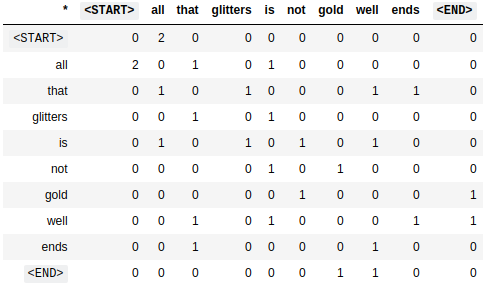
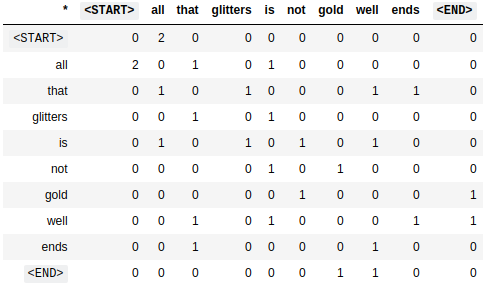

In [22]:
vector=TfidfVectorizer(max_features=5000)
train_vec=vector.fit_transform(X['Tags'])
train_vec=train_vec.toarray()

## Reviewing Vector shape

In [23]:
train_vec.shape

(720, 763)

## Saving vector and dataset in pickle format to recommend similar items in application

In [24]:
pickle.dump(train_vec, open('/kaggle/working/vector.pkl','wb'))
pickle.dump(df, open('/kaggle/working/restaurant-data.pkl','wb'))

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

## Using Cosine Similarity

In [26]:
similar_results=cosine_similarity(train_vec)

## correlation matrix created by cosine similarity

In [27]:
similar_results.shape

(720, 720)

In [28]:
def similar_names(word):
    word=word.lower()
    idx=df2[df2['Item-Name']==word].index[0]
    if df.loc[idx,'Restaurant-Name']=='Village - The Soul of India':
        # pasing index value of dishes in dataset to get 15 similar results
        similar_val=sorted(list(enumerate(similar_results[idx])), key=lambda x: x[1] ,reverse=True)[:15]
        count=1
        for val in similar_val:
            if count<6:
                print(df.loc[val[0],:])
            else:
                break
            count+=1

## Getting Similar suggestions related to soup or tomato soup

In [29]:
similar_names('tomato soup')

Id                                                                 8
Restaurant-Name                          Village - The Soul of India
Phone                                                +1 516-506-3655
Address            11 W Marie St, Hicksville, NY 11801, United St...
Item-Name                                                Tomato Soup
Item-type                                            Soups and Salad
Description                                            Not Mentioned
Price                                                           4.95
Name: 7, dtype: object
Id                                                               525
Restaurant-Name                                         Kiran Palace
Phone                                                +1 516-932-5191
Address            75 E Old Country Rd, Hicksville, NY 11801, Uni...
Item-Name                                                Tomato Soup
Item-type                                            Soups and Salad
Description

In [30]:
df2[df2['Item-Name']=='tomato soup']

,Id,Restaurant-Name,Item-Name,Item-type,Description,Price,Item-Name2,Tags
7,8,"[village, the, soul, of, india]",tomato soup,"[soups, and, salad]","[not, mentioned]",4.95,"[tomato, soup]",tomato soup soup salad mentioned
218,219,"[house, of, dosas]",tomato soup,"[soups, and, salad]","[mini, sized, idly, with, sambar, or, butter]",5.95,"[tomato, soup]",tomato soup soup salad mini sized idly sambar ...
524,525,"[kiran, palace]",tomato soup,"[soups, and, salad]","[not, mentioned]",5.95,"[tomato, soup]",tomato soup soup salad mentioned


# Splitting Training and test data for training and evaluation of model

In [31]:
x_train, x_test, y_train, y_test=train_test_split(train_vec, Y, test_size=0.01, random_state=42)

# Training Model using (XGBoost Regression)

In [32]:
xgb=XGBRegressor()
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Saving Model For prediction of price in application

In [33]:
pickle.dump(xgb, open('/kaggle/working/model.pkl','wb'))

In [34]:
pred=xgb.predict(x_test)

## Evaluating model performance over Validation data

In [35]:
print(f"Mean Squared Error: {mean_squared_error(y_test, pred)}")
print(f"R2-Score: {r2_score(y_test, pred)}")

Mean Squared Error: 1.782842234337335
R2-Score: 0.8339251819986786
